Grid‐best period: 2.62 d
Running MCMC…


100%|███████████████████████████████████████| 5000/5000 [04:14<00:00, 19.62it/s]



=== MCMC RESULTS ===
P  = 2.61656 ± 0.00005 d
K  = 73.648 ± 0.835 km/s
T0 = 59021.41848 ± 0.33200 d
γ  = -13.188 ± 0.667 km/s
e  = 0.0092 ± 0.0095
ω  = 359.97°

=== FIT QUALITY ===
N       = 42    # data points used
k       = 6    # fitted parameters
χ²      = 14.14
χ²_red  = 0.39 (χ²/dof)

Mass function f(m) = 0.10923 ± 0.00371 M☉


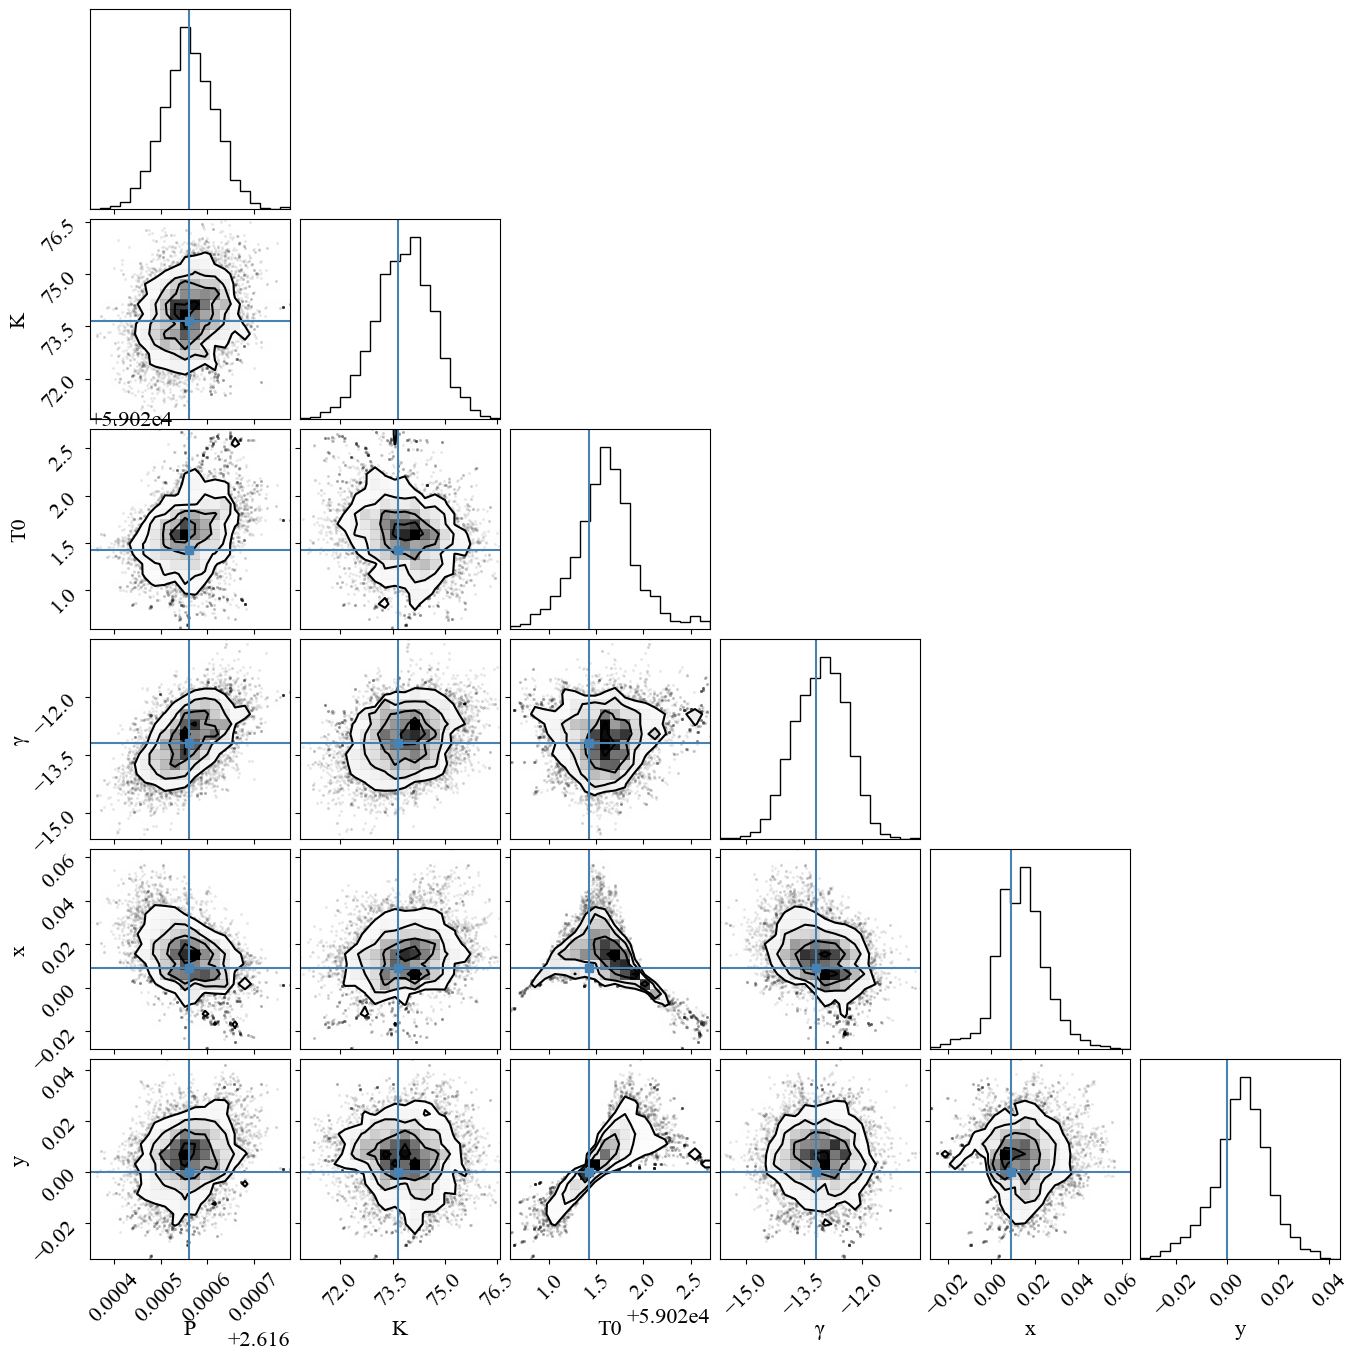

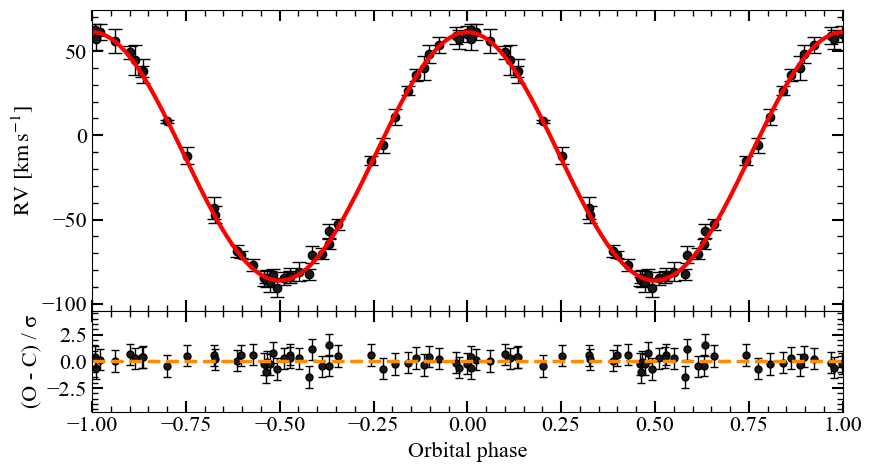

In [3]:
#!/usr/bin/env python3
"""
Universal RV MCMC fit with robust Kepler solver + mass function + χ² + styled plot.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import newton
import emcee, corner
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from pathlib import Path

# ─── SETTINGS ───────────────────────────────────────────────────────────────
data_file = Path('/Users/nadezhda/Documents/2025y/orb_param_issue/data/HR8523_RV_primary.dat')
fit_ecc   = True    # True → ellipse, False → circle
P0, dP    = 2.6, 0.5
K0, dK    = None, None
γ0, dγ0   = None, None
n_periods = 500
nsteps    = 5000
two_pi    = 2 * np.pi

# ─── 1) DATA LOADING & CLEANING ─────────────────────────────────────────────
df = pd.read_csv(data_file, delim_whitespace=True, header=None,
                 names=['HJD','RV','σ'])
df = df.replace([np.inf, -np.inf], np.nan).dropna()
t, rv, err = df.HJD.values, df.RV.values, df.σ.values

mask = err > 0
t, rv, err = t[mask], rv[mask], err[mask]

mask2 = np.abs(rv - np.median(rv)) < 5 * np.std(rv)
t, rv, err = t[mask2], rv[mask2], err[mask2]

if γ0 is None or dγ0 is None:
    γ0, dγ0 = np.median(rv), np.std(rv)
if K0 is None or dK is None:
    K0, dK = (rv.max() - rv.min()) / 2, (rv.max() - rv.min()) / 2

# ─── 2) GRID SEARCH FOR PERIOD (χ²) ──────────────────────────────────────────
periods = np.linspace(P0 - dP, P0 + dP, n_periods)
chi2    = []
for P in periods:
    φ     = two_pi / P * (t - t[0])
    A     = np.vstack([np.sin(φ), np.ones_like(t)]).T
    W     = np.diag(1 / err**2)
    sol   = np.linalg.inv(A.T @ W @ A) @ (A.T @ W @ rv)
    model = sol[1] + sol[0] * np.sin(φ)
    chi2.append(np.sum(((rv - model) / err)**2))

best_P = periods[np.argmin(chi2)]
print(f"Grid‐best period: {best_P:.2f} d")

# ─── 3) ORBITAL MODEL DEFINITION ────────────────────────────────────────────
def true_anomaly(M, e):
    M = M % (2 * np.pi)
    if e == 0.0:
        return M
    try:
        E = newton(lambda E: E - e * np.sin(E) - M, M, tol=1e-10, maxiter=50)
    except RuntimeError:
        E = M
        for _ in range(10):
            E = M + e * np.sin(E)
    return 2 * np.arctan2(np.sqrt(1 + e) * np.sin(E/2),
                          np.sqrt(1 - e) * np.cos(E/2))

def rv_model(t, P, K, T0, γ, x=0.0, y=0.0):
    e = np.hypot(x, y)
    ω = np.arctan2(y, x) % (2 * np.pi)
    M = two_pi / P * (t - T0)
    ν = np.array([true_anomaly(m, e) for m in M])
    return γ + K * (np.cos(ν + ω) + e * np.cos(ω))

# ─── 4) PRIORS & LIKELIHOOD ───────────────────────────────────────────────────
def log_prior(theta):
    if fit_ecc:
        P, K, T0, γ, x, y = theta
    else:
        P, K, T0, γ = theta
        x = y = 0.0
    lp = -0.5 * (((γ - γ0) / dγ0)**2 +
                 ((P - P0) / dP)**2 +
                 ((K - K0) / dK)**2)
    if not (0.2 * best_P < P < 5 * best_P):
        return -np.inf
    if not (0 < K < 5 * K0):
        return -np.inf
    if not (t.min() - P < T0 < t.max() + P):
        return -np.inf
    if fit_ecc and not (0 < np.hypot(x, y) < 1):
        return -np.inf
    return lp

def log_likelihood(theta):
    vals = theta if fit_ecc else (*theta, 0.0, 0.0)
    model = rv_model(t, *vals)
    if not np.all(np.isfinite(model)):
        return -np.inf
    return -0.5 * np.sum(((rv - model) / err)**2 + np.log(2 * np.pi * err**2))

def log_posterior(theta):
    lp = log_prior(theta)
    return lp + log_likelihood(theta) if np.isfinite(lp) else -np.inf

# ─── 5) MCMC SAMPLING WITH EMCEE ─────────────────────────────────────────────
theta0   = [best_P, K0, t[0], γ0] + ([0.1, 0.0] if fit_ecc else [])
ndim     = len(theta0)
nwalkers = 4 * ndim + 10
pos0     = theta0 + 1e-4 * np.random.randn(nwalkers, ndim)
sampler  = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

print("Running MCMC…")
sampler.run_mcmc(pos0, nsteps, progress=True)

# ─── 6) POST-PROCESSING & PARAMETER OUTPUT ─────────────────────────────────
burn  = nsteps // 5
chain = sampler.get_chain(discard=burn, thin=10, flat=True)
lp    = sampler.get_log_prob(discard=burn, thin=10, flat=True)
ml    = chain[np.argmax(lp)]

labels = ["P","K","T0","γ"] + (["x","y"] if fit_ecc else [])
corner.corner(chain, labels=labels, truths=ml).savefig("corner.png", dpi=200)

P_ml, K_ml, T0_ml, γ_ml = ml[0], ml[1], ml[2], ml[3]
x_ml, y_ml = (ml[4], ml[5]) if fit_ecc else (0.0, 0.0)
e_ml       = np.hypot(x_ml, y_ml)
ω_ml       = (np.arctan2(y_ml, x_ml) * 180 / np.pi) % 360

print("\n=== MCMC RESULTS ===")
print(f"P  = {P_ml:.5f} ± {np.std(chain[:,0]):.5f} d")
print(f"K  = {K_ml:.3f} ± {np.std(chain[:,1]):.3f} km/s")
print(f"T0 = {T0_ml:.5f} ± {np.std(chain[:,2]):.5f} d")
print(f"γ  = {γ_ml:.3f} ± {np.std(chain[:,3]):.3f} km/s")
if fit_ecc:
    print(f"e  = {e_ml:.4f} ± {np.std(np.hypot(chain[:,4],chain[:,5])):.4f}")
    print(f"ω  = {ω_ml:.2f}°")

# ─── 7) FIT QUALITY (χ²) ──────────────────────────────────────────────────────
model_best = rv_model(t, P_ml, K_ml, T0_ml, γ_ml, x_ml, y_ml)
N   = t.size
k   = ndim
dof = N - k
chi2     = np.sum(((rv - model_best) / err)**2)
chi2_red = chi2 / dof

print("\n=== FIT QUALITY ===")
print(f"N       = {N}    # data points used")
print(f"k       = {k}    # fitted parameters")
print(f"χ²      = {chi2:.2f}")
print(f"χ²_red  = {chi2_red:.2f} (χ²/dof)")

# ─── 8) MASS FUNCTION CALCULATION ────────────────────────────────────────────

G     = 6.67430e-11       # m^3 kg^-1 s^-2
day2s = 86400
M_sun = 1.989e30

P_samp = chain[:,0] * day2s
K_samp = chain[:,1] * 1e3
if fit_ecc:
    e_samp = np.hypot(chain[:,4], chain[:,5])
else:
    e_samp = np.zeros_like(P_samp)

f_samp = (K_samp**3 * P_samp) / (2*np.pi*G) * (1 - e_samp**2)**(-1.5) / M_sun
f_med, f_std = np.median(f_samp), np.std(f_samp)

print(f"\nMass function f(m) = {f_med:.5f} ± {f_std:.5f} M☉")

# ─── 9) PHASE-FOLDED PLOT + NORMALIZED O–C ──────────────────────────────────
# zero phase at periastron (T0_ml)
t0         = T0_ml
phase      = ((t - t0) / P_ml) % 1
phase_plot = np.linspace(-1, 1, 1000)
rv_fit     = rv_model(T0_ml + phase_plot * P_ml,
                      P_ml, K_ml, T0_ml, γ_ml, x_ml, y_ml)
res_nm     = (rv - rv_model(t, P_ml, K_ml, T0_ml, γ_ml, x_ml, y_ml)) / err

# duplicate for [-1,1]
phase_dup = np.concatenate([phase - 1, phase])
rv_dup    = np.concatenate([rv, rv])
err_dup   = np.concatenate([err, err])
res_dup   = np.concatenate([res_nm, res_nm])

# styling: Times New Roman + STIX
plt.rc('font', family='serif', serif=['Times New Roman'], size=16)
plt.rc('mathtext', fontset='stix')

fig, (ax1, ax2) = plt.subplots(
    2, 1, sharex=True, figsize=(9, 5),
    gridspec_kw={'height_ratios': [3, 1], 'hspace': 0}
)

def lighten_color(color, amount=0.1):
    c     = np.array(mcolors.to_rgb(color))
    white = np.ones_like(c)
    return tuple((1 - amount) * c + amount * white)

edge_color = 'black'
face_color = lighten_color(edge_color, amount=0.1)
ax1.errorbar(phase_dup, rv_dup, yerr=err_dup,
             fmt='o', ms=6,
             markeredgecolor=edge_color,
             markerfacecolor=face_color,
             ecolor=edge_color, elinewidth=1, capsize=5, zorder=1)
ax1.plot(phase_plot, rv_fit, '-', lw=3, color='red', zorder=2)
ax1.set_ylabel(r"$\mathrm{RV}\ [\mathrm{km\,s^{-1}}]$")
ax1.set_xlim(-1, 1)

edge_col2 = 'black'
face_col2 = lighten_color(edge_col2, amount=0.1)
ax2.errorbar(phase_dup, res_dup, yerr=np.ones_like(res_dup),
             fmt='o', ms=5,
             markeredgecolor=edge_col2,
             markerfacecolor=face_col2,
             ecolor='black', elinewidth=1, capsize=3,
             alpha=1, zorder=1)
ax2.axhline(0, color='darkorange', linestyle='--', lw=2.5, zorder=2)
ax2.set_xlim(-1, 1)
ax2.set_ylim(-4.7, 4.7)
ax2.set_xlabel('Orbital phase')
ax2.set_ylabel('(O - C) / σ')

for ax in (ax1, ax2):
    ax.xaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mticker.AutoMinorLocator())
    ax.tick_params(which='major', direction='in', length=8, width=1.5,
                   top=True, bottom=True, left=True, right=True)
    ax.tick_params(which='minor', direction='in', length=4, width=1.0,
                   top=True, bottom=True, left=True, right=True)

plt.tight_layout()
plt.savefig("rv_fit_HR8523_primary.pdf", dpi=300)
plt.show()